In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GroupShuffleSplit
import joblib
from copy import deepcopy
import gc
import random
import pickle
from scipy.stats import pearsonr, spearmanr
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt


# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)


In [2]:
def pearson_correlation_loss(pred, target):
    pred = pred - pred.mean(dim=0)
    target = target - target.mean(dim=0)
    
    numerator = torch.sum(pred * target, dim=0)
    denominator = torch.sqrt(torch.sum(pred ** 2, dim=0) * torch.sum(target ** 2, dim=0))
    
    return -torch.mean(numerator / (denominator + 1e-8))  # Add small epsilon for stability

In [3]:
ann = 'ann1'
scaling = True
cell_type = 'EpiT' #'EpiT, T', 'Endothelial'
#criterion = nn.MSELoss()
criterion = pearson_correlation_loss
cell_type_name = 'tumor_purity' #tumor_purity, endothelial_cells, T_cells
#full_output_dir = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_basic_test_FFPE_FF"
full_output_dir = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_optimize_training"
output_name = f"{cell_type}_dropout_0001"
title_plot = "Dropout, learning rate: 0.0001"

In [4]:
#FF
features_dir = "/home/evos/Outputs/CRC/FF/1_extract_histopathological_features/features.txt"
features_histo = pd.read_csv(features_dir, sep="\t")

#FFPE
# features_dir = "/home/evos/Outputs/CRC/FFPE/1_extract_histopathological_features/features_format_parquet"
# features_histo_dd = dd.read_parquet(f"{features_dir}/features-*.parquet")
# features_histo = features_histo_dd.compute()
# del features_histo_dd

print(len(features_histo))

220573


In [5]:
features_orion_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features_macenko/features.txt"
features_orion = pd.read_csv(features_orion_dir, sep="\t")
features_orion['slide_submitter_id'] = features_orion['tile_ID'].str.rsplit("-registered", n=1).str[0] + "-registered"
print(len(features_orion['slide_submitter_id'].unique()))

41


In [6]:
#add labels first deconv
# output_path = f"/home/evos/Outputs/CRC/deconvolution_sc/averaged_deconv_first_gen.csv"
# rectangle_estimation_first_gen =  pd.read_csv(output_path, sep=",", index_col=0)
# print(rectangle_estimation_first_gen.columns)

# # Filter rows with valid (non-NaN) values in the cell_type column for normalization
# filtered_df = rectangle_estimation_first_gen[[cell_type]].dropna()
# minmax_scaler = MinMaxScaler()
# filtered_df[cell_type] = minmax_scaler.fit_transform(filtered_df[cell_type].values.reshape(-1, 1)) #normalize the column

# filtered_df = filtered_df.drop_duplicates(keep='first')
# print(len(filtered_df))

# def get_base_id(sample_id):
#     return sample_id[:-1]  # Removes the last character

# features_histo['label'] = features_histo['sample_submitter_id'].apply(get_base_id).map(filtered_df[cell_type])
# features_histo = features_histo.dropna(subset=['label'])

# print(features_histo.head())
# print(len(features_histo))

# # features_histo = merged_features_histo.copy()
# # del merged_features_histo

In [7]:
#Add labels second deconv

output_path = f"/home/evos/Outputs/CRC/deconvolution_sc/final_sc_deconv_results/{ann}"
rectangle_estimation_ =  pd.read_csv(f"{output_path}/cell_frac_{ann}.csv", sep=",", index_col=0)
rectangle_estimation = rectangle_estimation_.where(rectangle_estimation_ >= 0, 0)
print(rectangle_estimation.columns)

if scaling == True:
    minmax_scaler = MinMaxScaler()
    cell_type_column = rectangle_estimation[cell_type].values.reshape(-1, 1)
    scaled_column = minmax_scaler.fit_transform(cell_type_column)
    rectangle_estimation_normalized = rectangle_estimation.copy() 
    rectangle_estimation_normalized[cell_type] = scaled_column.flatten()

    def get_base_id(sample_id):
        return sample_id[:-1]  # Removes the last character
    # Create a new column in df1 by mapping the modified 'sample_submitter_id'
    features_histo['label'] = features_histo['sample_submitter_id'].apply(get_base_id).map(rectangle_estimation_normalized[cell_type])

if scaling == False:
    def get_base_id(sample_id):
        return sample_id[:-1]  # Removes the last character
    # Create a new column in df1 by mapping the modified 'sample_submitter_id'
    features_histo['label'] = features_histo['sample_submitter_id'].apply(get_base_id).map(rectangle_estimation[cell_type])

print(len(features_histo))
#del rectangle_estimation

Index(['B', 'EpiT', 'Macro', 'Mast', 'Plasma', 'Stromal', 'T', 'Unknown'], dtype='object')
220573


In [8]:
def patch_sampling(features_hist, n_patches_per_slide, min_patches_per_slide=100, sample_all=False):
    """
    Samples a fixed number of patches from each slide in the features_hist DataFrame.
    Slides with fewer than min_patches_per_slide patches are excluded.
    
    Parameters:
    - features_hist: pandas DataFrame containing the feature data for each slide
    - n_patches_per_slide: Number of patches to sample per slide (ignored if sample_all=True)
    - min_patches_per_slide: Minimum number of patches required to include a slide in the sampled data
    - sample_all: If True, all patches are sampled, otherwise a fixed number is sampled per slide
    
    Returns:
    - features_hist_sampled: A new DataFrame with sampled patches for each slide
    """
    features_hist_sampled = []

    # Group by 'slide_submitter_id' to sample patches for each slide
    for slide_id, group in features_hist.groupby('slide_submitter_id'):
        # Exclude slides with fewer than the minimum number of patches
        if len(group) < min_patches_per_slide:
            continue

        if sample_all:
            # If sampling all patches, just use the entire group
            sampled_group = group
        else:
            # Otherwise, sample a fixed number of patches
            n_patches = min(n_patches_per_slide, len(group))
            sampled_group = group.sample(n=n_patches, random_state=42)

        features_hist_sampled.append(sampled_group)

    # Concatenate all the sampled patches back into a single DataFrame
    features_hist_sampled = pd.concat(features_hist_sampled, axis=0)

    return features_hist_sampled


In [9]:
# Initialize GroupShuffleSplit
n_randomstate = 41 #40,41,42,43,44
print(len(features_histo))
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=n_randomstate) #40,41,42,43,44

# Perform the split based only on groups
for train_idx, test_idx in group_split.split(features_histo, groups=features_histo['slide_submitter_id']):
    df_train_val = features_histo.iloc[train_idx]
    df_test = features_histo.iloc[test_idx]

del features_histo

#Apply sampling on df_train_val dataset
df_train_val = patch_sampling(df_train_val,500,50,sample_all=True)
df_test = patch_sampling(df_test,300,50,sample_all=True)

# Verify the split
print(len(df_train_val['slide_submitter_id'].unique()))
print(len(df_test['slide_submitter_id'].unique()))

kf = KFold(n_splits=5, shuffle=True, random_state=n_randomstate) # 5 folds with shuffling #40,41,42,43,54
folds = []

print(len)
unique_slide_ids = df_train_val['slide_submitter_id'].unique()
print(len(unique_slide_ids))

# Generate indices for cross-validation
for train_idx, val_idx in kf.split(unique_slide_ids):
    train_slide_ids = unique_slide_ids[train_idx]
    val_slide_ids = unique_slide_ids[val_idx]
    folds.append((train_slide_ids, val_slide_ids))

for fold, (train_ids, val_ids) in enumerate(folds):
    print(f"Fold {fold + 1}:")
    print(f"  Training slides: {len(train_ids)}")
    print(f"  Validation slides: {len(val_ids)}")
print(f"Train/val patches: {len(df_train_val)}")
print(f"Test patches: {len(df_test)}")

220573
219
56
<built-in function len>
219
Fold 1:
  Training slides: 175
  Validation slides: 44
Fold 2:
  Training slides: 175
  Validation slides: 44
Fold 3:
  Training slides: 175
  Validation slides: 44
Fold 4:
  Training slides: 175
  Validation slides: 44
Fold 5:
  Training slides: 176
  Validation slides: 43
Train/val patches: 177051
Test patches: 43497


In [10]:
class MILDataset(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        label = torch.tensor(self.bag_data[slide_id]['label'], dtype=torch.float32)
        return features, label  # Returns patch features and slide-level continuous label
    
def collate_fn(batch):
    features = [item[0] for item in batch]  # List of feature tensors
    labels = torch.tensor([item[1] for item in batch])  # List of labels
    return features, labels
    
def pearson_correlation_loss(pred, target):
    pred = pred - pred.mean(dim=0)
    target = target - target.mean(dim=0)
    
    numerator = torch.sum(pred * target, dim=0)
    denominator = torch.sqrt(torch.sum(pred ** 2, dim=0) * torch.sum(target ** 2, dim=0))
    
    return -torch.mean(numerator / (denominator + 1e-8))  # Add small epsilon for stability

In [11]:
def standardize_features_incremental(df_train, df_val, feature_columns=None):
    """
    Standardizes the features in df_train and df_val using an incremental approach.
    This avoids fitting the scaler to the entire dataset at once, making it more memory efficient.
    
    Parameters:
    - df_train: pandas DataFrame containing the training data
    - df_val: pandas DataFrame containing the validation data
    - feature_columns: list of feature column names (if None, assumes all columns except 'label' and identifiers)
    
    Returns:
    - df_train: pandas DataFrame with standardized features for training
    - df_val: pandas DataFrame with standardized features for validation
    - scaler: StandardScaler object fitted on the training data
    """
    if feature_columns is None:
        feature_columns = df_train.columns[:-2]  # Assuming last two columns are 'label' and identifier
    
    # Initialize variables for incremental mean and variance computation
    n_samples = 0
    mean_sum = np.zeros(len(feature_columns))
    var_sum = np.zeros(len(feature_columns))
    
    # Incrementally compute the mean and variance for the training data
    for slide_id, group in df_train.groupby('slide_submitter_id'):
        features = group[feature_columns].values
        n_samples += features.shape[0]
        mean_sum += features.sum(axis=0)
        var_sum += (features ** 2).sum(axis=0)
    
    # Final mean and variance
    mean = mean_sum / n_samples
    variance = (var_sum / n_samples) - (mean ** 2)
    std_dev = np.sqrt(np.maximum(variance, 1e-8))  # Avoid division by zero
    
    # Apply the standardization to both the training and validation data
    df_train[feature_columns] = (df_train[feature_columns] - mean) / std_dev
    df_val[feature_columns] = (df_val[feature_columns] - mean) / std_dev
    
    # Create a scaler object that contains the mean and standard deviation
    scaler = StandardScaler()
    scaler.mean_ = mean
    scaler.scale_ = std_dev
    scaler.var_ = variance
    
    return df_train, df_val, scaler


In [12]:
# class PatchClassifier(nn.Module):
#     def __init__(self):
#         super(PatchClassifier, self).__init__()
#         self.fc1 = nn.Linear(in_features=1536, out_features=256)  # Adjust input size as needed
#         self.fc2 = nn.Linear(256, 64)
#         self.fc_last = nn.Linear(64, 1)  # Output one probability

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc_last(x))  # Sigmoid to get probabilities
#         return x

class PatchClassifier(nn.Module):
    def __init__(self):
        super(PatchClassifier, self).__init__()
        self.fc1 = nn.Linear(1536, 256)
        self.dropout1 = nn.Dropout(p=0.5)  # Drop 50% of neurons
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(p=0.3)  # Drop 30%
        self.fc_last = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = torch.sigmoid(self.fc_last(x))
        return x

# class PatchClassifier(nn.Module):
#     def __init__(self):
#         super(PatchClassifier, self).__init__()
#         self.fc1 = nn.Linear(in_features=1536, out_features=256)  # Adjust input size as needed
#         self.dropout = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(256, 64)
#         self.fc_last = nn.Linear(64, 1)  # Output one probability

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = torch.sigmoid(self.fc_last(x))  # Sigmoid to get probabilities
#         return x
    
# class PatchClassifier(nn.Module):
#     def __init__(self):
#         super(PatchClassifier, self).__init__()
#         self.fc1 = nn.Linear(1536, 128)  # Reduced neurons
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x

In [13]:
num_epochs = 30
patience = 5
batch_size = 28
#model_name = PatchClassifier()

# Store losses for each fold
fold_train_losses = {}
fold_val_losses = {}

for fold, (train_ids, val_ids) in enumerate(folds):
    print(f"Training Fold {fold + 1}")
    
    model = PatchClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    features_train_val = df_train_val.copy()
    # Create training and validation datasets
    df_train = features_train_val[features_train_val['slide_submitter_id'].isin(train_ids)]
    df_val = features_train_val[features_train_val['slide_submitter_id'].isin(val_ids)]

    # Count the number of tiles (patches) in training and validation sets
    train_tiles_count = df_train['tile_ID'].nunique()  # or use .shape[0] for number of rows
    val_tiles_count = df_val['tile_ID'].nunique()      # assuming 'tile_ID' is the identifier for each patch
    
    print(f"Number of tiles in training set for Fold {fold + 1}: {train_tiles_count}")
    print(f"Number of tiles in validation set for Fold {fold + 1}: {val_tiles_count}")
    
    remove_columns = ['Unnamed: 0', 'tile_ID', 'sample_submitter_id', 'Section', 'Coord_X', 'Coord_Y']
    # Clean the datasets
    df_train_clean = df_train.drop(columns=[col for col in remove_columns if col in df_train.columns])
    df_val_clean = df_val.drop(columns=[col for col in remove_columns if col in df_val.columns])

    #df_train_clean, df_val_clean, scaler = standardize_features_incremental(df_train_clean, df_val_clean)

    #Standardize features (fit on training data and transform both train and validation data)
    feature_columns = df_train_clean.columns[:-2]  # Select all feature columns except 'label' and 'slide_submitter_id'
    scaler = StandardScaler()
    df_train_clean[feature_columns] = scaler.fit_transform(df_train_clean[feature_columns])
    df_val_clean[feature_columns] = scaler.transform(df_val_clean[feature_columns])
    
    # Bag the data
    bag_data_train = {}
    for slide_id, group in df_train_clean.groupby('slide_submitter_id'):
        features = group.iloc[:, 0:-2].values
        label = group['label'].iloc[0]
        bag_data_train[slide_id] = {'features': features, 'label': label}

    bag_data_val = {}
    for slide_id, group in df_val_clean.groupby('slide_submitter_id'):
        features = group.iloc[:, 0:-2].values
        label = group['label'].iloc[0]
        bag_data_val[slide_id] = {'features': features, 'label': label}

    # Create datasets and loaders
    mil_dataset_train = MILDataset(bag_data_train)
    mil_loader_train = DataLoader(mil_dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    mil_dataset_val = MILDataset(bag_data_val)
    mil_loader_val = DataLoader(mil_dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

    # Early stopping parameters
    best_val_loss = float('inf')
    counter = 0  # Tracks how many epochs have passed without improvement

    train_losses = []
    val_losses = []

    #TRAIN THE MODEL
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0

        for batch_features, batch_labels in mil_loader_train:
            optimizer.zero_grad()  # Zero gradients
            batch_predictions = []
                
            for features in batch_features:  # Iterate through each tensor in the batch
                patch_predictions = model(features)  # Get predictions for the patches
                aggregated_prediction = patch_predictions.mean()  # Aggregate predictions
                batch_predictions.append(aggregated_prediction)

            batch_predictions = torch.stack(batch_predictions)

            #batch_labels = batch_labels.unsqueeze(1)
            loss = criterion(batch_predictions, batch_labels)
            total_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Validate the model after each epoch
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0

        with torch.no_grad():  # No gradient calculation needed during validation
            for val_features, val_labels in mil_loader_val:
                batch_predictions = []

                for features in val_features:  # Iterate through each tensor in the batch
                    patch_predictions = model(features)  # Get predictions for the patches
                    aggregated_prediction = patch_predictions.mean()  # Aggregate predictions
                    batch_predictions.append(aggregated_prediction)

                batch_predictions = torch.stack(batch_predictions)
        
                #val_labels = val_labels.unsqueeze(1)
                val_loss = criterion(batch_predictions, val_labels)
                total_val_loss += val_loss.item()
        
        avg_train_loss = total_loss / len(mil_loader_train)
        avg_val_loss = total_val_loss / len(mil_loader_val)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset patience counter
            torch.save(model.state_dict(), f"saved_models/model_fold_{fold}.pth")  # Save the best model
        else:
            counter += 1  # Increment patience counter
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break  # Stop training

    #Store loss history for this fold
    fold_train_losses[fold] = train_losses
    fold_val_losses[fold] = val_losses
        
    # Save the model and scaler for each fold into the dictionaries
    #models[fold] = deepcopy(model)  # Save the model for the fold
    #scalers[fold] = deepcopy(scaler)  # Save the scaler for the fold
  
    torch.save(model.state_dict(), f"saved_models/model_fold_{fold}.pth")
    joblib.dump(scaler, f"saved_scalers/scaler_fold_{fold}.pkl")    

    # Clear fold-specific variables
    del model, scaler, df_train, df_val, df_train_clean, df_val_clean
    del bag_data_train, bag_data_val, mil_dataset_train, mil_loader_train
    del mil_dataset_val, mil_loader_val
    del feature_columns, features
    del batch_features, batch_predictions, batch_labels
    del features_train_val
    #del val_features, val_labels

    # Release GPU memory and perform garbage collection
    torch.cuda.empty_cache()
    gc.collect()

# Save the entire dictionary of models and scalers to one file
# torch.save(models, "models_all_folds.pth")  # Save the models as a single file
# joblib.dump(scalers, "scalers_all_folds.pkl")  # Save the scalers as a single file

Training Fold 1
Number of tiles in training set for Fold 1: 146994
Number of tiles in validation set for Fold 1: 30057
Epoch 1/30, Training Loss: -0.2306533886918, Validation Loss: -0.5571163296699524
Epoch 2/30, Training Loss: -0.6373261851923806, Validation Loss: -0.5601557791233063
Epoch 3/30, Training Loss: -0.7362913489341736, Validation Loss: -0.5832976400852203
Epoch 4/30, Training Loss: -0.6886087954044342, Validation Loss: -0.6003603339195251
Epoch 5/30, Training Loss: -0.8431810055460248, Validation Loss: -0.5917074680328369
Epoch 6/30, Training Loss: -0.8107034904616219, Validation Loss: -0.5829837620258331
Epoch 7/30, Training Loss: -0.8554714322090149, Validation Loss: -0.5693115592002869
Epoch 8/30, Training Loss: -0.8593899777957371, Validation Loss: -0.5987346470355988
Epoch 9/30, Training Loss: -0.8815331884792873, Validation Loss: -0.6115382313728333
Epoch 10/30, Training Loss: -0.8822443059512547, Validation Loss: -0.5882475972175598
Epoch 11/30, Training Loss: -0.90

In [14]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))

# # Define distinct colors manually (modify as needed)
# fold_colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']  # Red, Blue, Green, Purple, Orange

# for fold in range(len(folds)):  
#     color = fold_colors[fold % len(fold_colors)]  # Cycle through colors if more folds exist
#     plt.plot(range(1, len(fold_train_losses[fold]) + 1), fold_train_losses[fold], 
#              label=f'Train Loss Fold {fold+1}', linestyle='--', color=color)
#     plt.plot(range(1, len(fold_val_losses[fold]) + 1), fold_val_losses[fold], 
#              label=f'Val Loss Fold {fold+1}', linestyle='-', color=color)

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training vs Validation Loss per Fold')
# plt.legend()
# plt.grid(True)

# output_dir_loss_curves = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_optimize_training"
# plt.savefig(f"{output_dir_loss_curves}/{output_name}.png", dpi=300, bbox_inches='tight')
# plt.show()



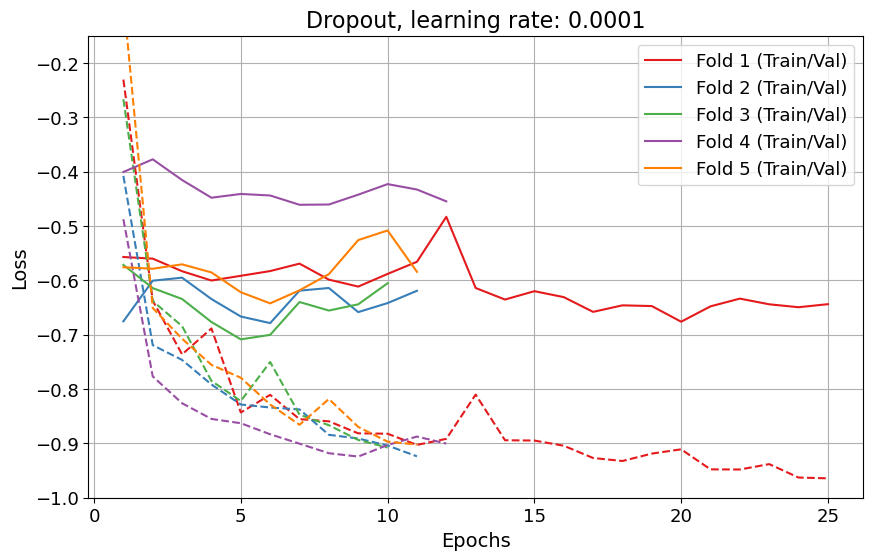

In [15]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.figure(figsize=(10,6))

fold_colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']  # Custom colors
legend_handles = []  # Store legend handles

for fold in range(len(folds)):  
    color = fold_colors[fold % len(fold_colors)]  # Cycle through colors if more folds exist
    
    # Plot training and validation loss with same color
    plt.plot(range(1, len(fold_train_losses[fold]) + 1), fold_train_losses[fold], linestyle='--', color=color)
    plt.plot(range(1, len(fold_val_losses[fold]) + 1), fold_val_losses[fold], linestyle='-', color=color)
    
    # Create a single legend entry for each fold
    legend_handles.append(mlines.Line2D([], [], color=color, label=f'Fold {fold+1} (Train/Val)'))

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title(f"{title_plot}", fontsize=16)
plt.legend(handles=legend_handles, loc='upper right', fontsize=13)  # Compact legend
plt.grid(True)
plt.xticks(fontsize=13) 
plt.ylim(-1, -0.15)
plt.yticks(fontsize=13)

output_dir_loss_curves = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_optimize_training"
plt.savefig(f"{output_dir_loss_curves}/{output_name}.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# features_orion_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features_macenko/features.txt"
# features_orion = pd.read_csv(features_orion_dir, sep="\t")
# features_orion['slide_submitter_id'] = features_orion['tile_ID'].str.rsplit("-registered", n=1).str[0] + "-registered"
# print(len(features_orion['slide_submitter_id'].unique()))

In [17]:
class MILDatasetTest(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        label = torch.tensor(self.bag_data[slide_id]['label'], dtype=torch.float32)
        patch_ids = self.bag_data[slide_id]['patch_ids']  # Add patch IDs
        return features, label, patch_ids  # Returns patch features, slide-level label, and patch IDs

class MILDatasetTestOrion(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        patch_ids = self.bag_data[slide_id]['patch_ids']  # Add patch IDs
        return features, patch_ids  # Returns patch features, slide-level label, and patch IDs

remove_columns_test = ['Unnamed: 0', 'sample_submitter_id', 'Section', 'Coord_X', 'Coord_Y']
df_test_clean = df_test.drop(columns=[col for col in remove_columns_test if col in df_test.columns])
df_test_orion = features_orion.drop(columns=[col for col in remove_columns_test if col in features_orion.columns])

#del df_test
#del features_orion

print(len(df_test_clean.columns))
print(len(df_test_orion.columns))

bag_data_test = {}
for slide_id, group in df_test_clean.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-3].values  # All feature columns
    label = group['label'].iloc[0]  # Continuous slide label
    bag_data_test[slide_id] = {'features': features, 'label': label, 'patch_ids': group['tile_ID'].tolist()}

bag_data_test_orion = {}
for slide_id, group in df_test_orion.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-2].values  # All feature columns
    bag_data_test_orion[slide_id] = {'features': features,  'patch_ids': group['tile_ID'].tolist()}


1539
1538


In [18]:
#models = torch.load("models_all_folds.pth", weights_only=True)
# Initialize dictionaries for models and scalers
models = {}
scalers = {}

# Load models and scalers for each fold
for fold in range(5):  # Assuming 5 folds
    # Load model
    model = PatchClassifier() # Instantiate the model architecture
    model.load_state_dict(torch.load(f"saved_models/model_fold_{fold}.pth"))
    model.eval()  # Set the model to evaluation mode
    models[fold] = model  # Add to the dictionary

    # Load scaler
    scaler = joblib.load(f"saved_scalers/scaler_fold_{fold}.pkl")
    scalers[fold] = scaler  # Add to the dictionary

# Initialize containers for cross-fold results
all_final_predictions = []
all_true_labels = []
all_patch_probabilities = []
all_patch_IDs = []

for fold in range(5):  # Assuming 5 folds
    print(f"Evaluating Fold {fold + 1}")
    
    # Retrieve the model and scaler for the current fold
    model = models[fold]
    scaler = scalers[fold]
    
    # Normalize the test data using the current fold's scaler
    normalized_bag_data_test = deepcopy(bag_data_test)
    for slide_id in normalized_bag_data_test:
        # Create a DataFrame with the same column names used during training
        features_df = pd.DataFrame(
            normalized_bag_data_test[slide_id]['features'], 
            columns=scaler.feature_names_in_  # Use feature names from the scaler
        )
        # Normalize using the scaler
        normalized_bag_data_test[slide_id]['features'] = scaler.transform(features_df)
    
    # Create the test dataset and DataLoader
    mil_dataset_test = MILDatasetTest(normalized_bag_data_test)
    mil_loader_test = DataLoader(mil_dataset_test, batch_size=1, shuffle=False)
    
    # Collect predictions for the current fold
    fold_patch_probabilities = []
    fold_patch_IDs = []
    fold_final_predictions = []
    fold_true_labels = []
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for features, labels, patch_ids in mil_loader_test:
            # Get patch probabilities (since each bag has size 1)
            patch_predictions = model(features.squeeze(0))  # Remove extra dimension
            
            # Collect patch probabilities for the current slide
            fold_patch_probabilities.append(patch_predictions.numpy())
            fold_patch_IDs.append(patch_ids)
            
            # Aggregate to get the final prediction (mean of patch probabilities)
            final_prediction = patch_predictions.mean().item()
            fold_final_predictions.append(final_prediction)
            fold_true_labels.append(labels.item())
    
    # Store fold results
    all_patch_probabilities.append(fold_patch_probabilities)
    all_patch_IDs.append(fold_patch_IDs)
    all_final_predictions.append(fold_final_predictions)
    all_true_labels.append(fold_true_labels)

/tmp/ipykernel_36240/2384066108.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"saved_models/model_fold_{fold}.pth"))


Evaluating Fold 1
Evaluating Fold 2
Evaluating Fold 3
Evaluating Fold 4
Evaluating Fold 5


Average final predictions: [0.47730607 0.47214064 0.48849968 0.48204075 0.45450835 0.48371447
 0.4864136  0.47549721 0.4827154  0.44793945 0.42111548 0.47553316
 0.48146697 0.48026154 0.46322831 0.48699716 0.48762906 0.44698243
 0.48415979 0.48032568 0.48597313 0.47367222 0.4800854  0.40507005
 0.48980506 0.48708628 0.48688059 0.49263176 0.48734345 0.47962695
 0.49243009 0.46339172 0.49445168 0.48961512 0.48499895 0.47427554
 0.45431099 0.47364845 0.4844386  0.44895626 0.47423099 0.48075037
 0.4807421  0.49002311 0.49190141 0.49107581 0.45086502 0.46890507
 0.42376458 0.46980905 0.49711445 0.483422   0.4762743  0.45786151
 0.43189772 0.50311117]
True Labels: [0.64453709 0.83823133 0.87607032 0.92480427 0.68002594 0.93427086
 0.93427086 0.87981004 0.87981004 0.67828816 0.48335207 0.68284363
 0.94330627 0.85208297 0.8149429  0.83322173 0.93161315 0.63113797
 0.83499718 0.85873139 0.96458507 0.73169172 0.75698793 0.34911266
 0.99131417 0.87856263 0.76950705 0.80585659 0.80585659 0.9178023

<Axes: >

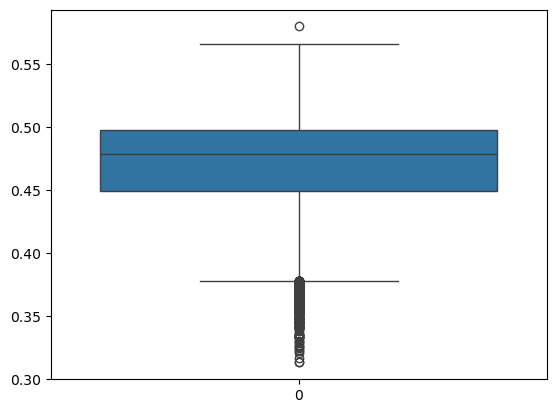

In [19]:
true_labels = all_true_labels[0]
average_final_predictions = np.mean(all_final_predictions, axis=0)

concatenated_patch_probabilities = []
for fold in range(5):
    concatenated_patches = np.concatenate(all_patch_probabilities[fold], axis=0)
    concatenated_patch_probabilities.append(concatenated_patches)
average_patch_probabilities = np.mean(concatenated_patch_probabilities, axis=0)
    
print("Average final predictions:", average_final_predictions)
print("True Labels:", np.array(true_labels))

#average_final_predictions =  all_final_predictions[1]
test_mae = mean_absolute_error(true_labels, average_final_predictions)
print(f"Test Mean Absolute Error: {test_mae:.5f}")
test_mse = mean_squared_error(true_labels, average_final_predictions)
print(f"Test Mean Squared Error: {test_mse:.5f}")
pearson_correlation, _ = pearsonr(true_labels, average_final_predictions)
print(f"Pearson correlation: {pearson_correlation:.4f}")
spearman_correlation, _ = spearmanr(true_labels, average_final_predictions)
print(f"Spearman correlation: {spearman_correlation:.4f}")

sns.boxplot(data=average_patch_probabilities)


Evaluating Fold 1
Evaluating Fold 2
Evaluating Fold 3
Evaluating Fold 4
Evaluating Fold 5
[0.44181421 0.44796987 0.45951068 0.44150718 0.42201374 0.42964718
 0.43322734 0.44480917 0.42839352 0.42028661 0.42868876 0.44033787
 0.43341838 0.42312794 0.41885098 0.4507728  0.44253106 0.43265616
 0.44364632 0.44480094 0.42909284 0.43189195 0.4485062  0.41952122
 0.42918534 0.43499015 0.43492743 0.44542954 0.42955274 0.43146886
 0.43199909 0.4235236  0.43736259 0.44834906 0.44080248 0.42304103
 0.43851646 0.44176783 0.42771284 0.44178272 0.45303383]


<Axes: >

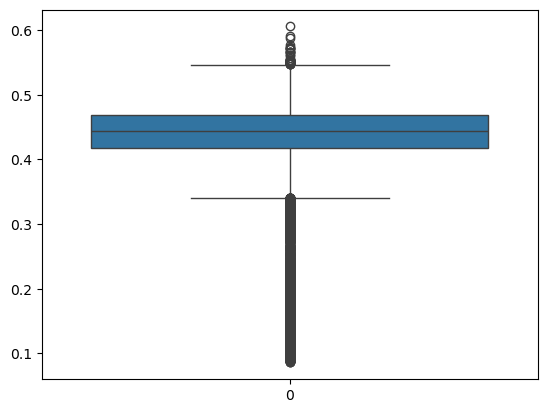

In [20]:
# Initialize containers for cross-fold results
all_final_predictions = []
all_true_labels = []
all_patch_probabilities = []
all_patch_IDs = []

for fold in range(5):  # Assuming 5 folds
    print(f"Evaluating Fold {fold + 1}")
    
    # Retrieve the model and scaler for the current fold
    model = models[fold]
    scaler = scalers[fold]
    
    # Normalize the test data using the current fold's scaler
    normalized_bag_data_orion = deepcopy(bag_data_test_orion)
    for slide_id in normalized_bag_data_orion:
        # Create a DataFrame with the same column names used during training
        features_df = pd.DataFrame(
            normalized_bag_data_orion[slide_id]['features'], 
            columns=scaler.feature_names_in_  # Use feature names from the scaler
        )
        # Normalize using the scaler
        normalized_bag_data_orion[slide_id]['features'] = scaler.transform(features_df)
    
    # Create the test dataset and DataLoader
    mil_dataset_orion = MILDatasetTestOrion(normalized_bag_data_orion)
    mil_loader_orion = DataLoader(mil_dataset_orion, batch_size=1, shuffle=False)
    
    # Collect predictions for the current fold
    fold_patch_probabilities = []
    fold_patch_IDs = []
    fold_final_predictions = []
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for features, patch_ids in mil_loader_orion:
            # Get patch probabilities (since each bag has size 1)
            patch_predictions = model(features.squeeze(0))  # Remove extra dimension
            
            # Collect patch probabilities for the current slide
            fold_patch_probabilities.append(patch_predictions.numpy())
            fold_patch_IDs.append(patch_ids)
            
            # Aggregate to get the final prediction (mean of patch probabilities)
            final_prediction = patch_predictions.mean().item()
            fold_final_predictions.append(final_prediction)
    
    # Store fold results
    all_patch_probabilities.append(fold_patch_probabilities)
    all_patch_IDs.append(fold_patch_IDs)
    all_final_predictions.append(fold_final_predictions)

average_final_predictions = np.mean(all_final_predictions, axis=0)

concatenated_patch_probabilities = []
for fold in range(5):
    concatenated_patches = np.concatenate(all_patch_probabilities[fold], axis=0)
    concatenated_patch_probabilities.append(concatenated_patches)
average_patch_probabilities = np.mean(concatenated_patch_probabilities, axis=0)

concatenated_patch_IDs = np.concatenate(all_patch_IDs[0], axis=0)

print(average_final_predictions)
sns.boxplot(data=average_patch_probabilities)

In [21]:
#cell_type_name = 'tumor_purity' #tumor_purity, endothelial_cells, T_cells

dataframes = []
# Iterate through each sublist of tuples and corresponding probabilities
for patch_ids, probabilities in zip(concatenated_patch_IDs, average_patch_probabilities):
    df = pd.DataFrame({
        'tile_ID': patch_ids,
        cell_type_name: probabilities
    })
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into one big DataFrame
final_dataframe = pd.concat(dataframes, ignore_index=True)
final_dataframe['tile_ID'] = final_dataframe['tile_ID'].astype(str)

#split_columns = final_dataframe['tile_ID'].str.split("_", 2, expand=True)
split_columns = final_dataframe['tile_ID'].str.rsplit("_", n=2, expand=True)

# Assign the new columns from the split results
final_dataframe['slide_id'] = split_columns[0]
final_dataframe['Coord_X'] = split_columns[1]
final_dataframe['Coord_Y'] = split_columns[2]

print(final_dataframe.head())

# full_output_dir = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_basic_tests/simple_nn_no_norm_MSE"
#final_dataframe.to_csv(f"{full_output_dir}/{cell_type}_norm_cor.csv", sep="\t", index=False)
final_dataframe.to_csv(f"{full_output_dir}/{output_name}.csv", sep="\t", index=False)

                                             tile_ID  tumor_purity  \
0  18459_LSP10353_US_SCAN_OR_001__093059-register...      0.484167   
1  18459_LSP10353_US_SCAN_OR_001__093059-register...      0.491759   
2  18459_LSP10353_US_SCAN_OR_001__093059-register...      0.457183   
3  18459_LSP10353_US_SCAN_OR_001__093059-register...      0.424417   
4  18459_LSP10353_US_SCAN_OR_001__093059-register...      0.474138   

                                           slide_id Coord_X Coord_Y  
0  18459_LSP10353_US_SCAN_OR_001__093059-registered   12800    2048  
1  18459_LSP10353_US_SCAN_OR_001__093059-registered   20480   24064  
2  18459_LSP10353_US_SCAN_OR_001__093059-registered   14336   22016  
3  18459_LSP10353_US_SCAN_OR_001__093059-registered   27648    3072  
4  18459_LSP10353_US_SCAN_OR_001__093059-registered   13824   18944  
